# STDP spiking classifier for somatosensory data

#### Reason for doing SNN
- I brought up doing SNN for information processing in the spiking sensory data
- So the current goal is to integrate spiking information processing with the spiking sensory inputs

#### first choice is what tool to use for building the network
tried pytorch derived ML frameworks first, but soon realised not the right tool for the job because
- Not enough granularity or clarity
- Lack of support, a lot of dependency issues and such
- Lack of documentation

Therefore chose to use frameworks meant for neuroscience (brian) which allow for defining specific differential equations for the behaviour of each paramater of every neuron and to choose biologically plausible units and quantities

## overview of architecture
![image.png](Figures/SNN_network_overview.png)

(adapted from [2])

- LIF voltage-behaviour
- spikes change post-synaptic neurons' conductance
- STDP learning rule
- Classification by highest average activity level of neurons assigned to a given class
- Lateral inhibition

![image.png](Figures/STDP_learning_rule.jpg)



#### Why this architecture was chosen
- Ease of implementing another input group for multi-modality and then connecting those groups to create interesting architectures
    - Training with STDP to associate two inputs and then classification with just one or many, comparing performance and analysis of the activity of neurons for the different modality but which are not currently receiving input
- Entirely bio-inspired and local
- Researchers at ETH [3] (and elsewhere [2]) have created hardware implementations of similar networks, so if/when we get to creating hardware there is a place to start
- Lateral inhibition built into the network, which is the lowest level explanation for the visual phenomena of the ackerson checkerboard, which Hongwei wanted to study

#### Encoding the input

- To encode vector data (with just magnitudes of input), these were translated into poisson distributed firing with a frequency related to the magnitude. Reason for poisson rather than just rate is biological plausibility, at low intensities sensory neurons show poisson spiking
- To encode the spike data, I specified the input neurons to have their voltage driven by the temporal spike encoded data from the sensory devices, so that is 'dv/dt = -v + stimulus(t)'

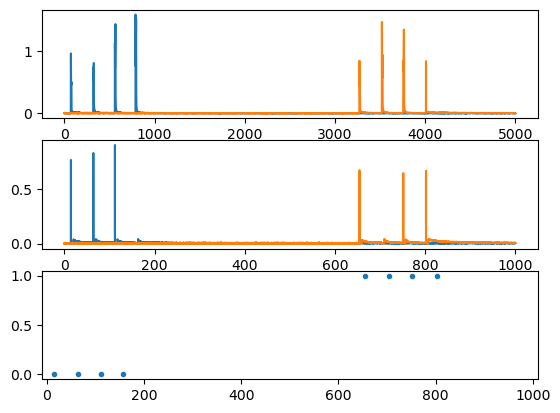

In [147]:
data_voltage_input_fig

#### Some runs the somatosensory data

- First functioning run with n_e = 400 w/ rate encoding (also there is a minor inaccuracy in the synapses from excitatory to inhibitory layer

![image.png](Figures/n_e_400_rate_encoding_accuracy.png)

(run was stopped because time, that's why zero after the first quarter, but overall in line with growth of classification accuracy from [1], which started to approach its asymptote at around 200 000 examples or so)

![image.png](Figures/n_e_30_rate_encoding_accuracy.png)

- Odd behaviour jumping between 0 and 90, discovered it is because of a skips for homeostasis
- But hey at least it learnt to distinguish between the inputs fast which shows the potential for the architecture
- changing the skipping to rather increase intensity and run the 
    - Indicating an issue with the data, where some datapoints have very low magnitudes in every dimension, causing the system to keep looping over these values (particularly the letter I) until the frequency is increased a lot and the data appears different along with causing issues with increasing frequency degrading the amount of information because of the biologically plausible system.
    - So better data for this particular architecture would be of higher dimensionality and more homogeneous in levels of global intensities per data item and less classes to classify between


##### Running temporal data currently runs at about half of real time (So a single sample takes 20s to run)
- Solution to this problem is to a) implement gpu, b) figure out a better way to encode spikes instead of driving the voltage, so that is just encode spike timings directly, would be waaay quicker. Can maybe be done in software, but would be nice to integrate with hardware directly c) optimize parameters


#### Homeostatic mechanisms

- Prior to STDP normalize input weight such that the sum of inputs to any given excitatory layer neuron is in accordance to a variable, currently 78
- If not enough spikes in the second layer then increase intensity (average frequency) of input and run again
    - Note: had to think of a different way to do this with temporal data, cause there is no intensity to increase, just ended up increasing the weights, hopefully it works as intended
- variable spike threshold
- refractive period


#### Next steps

- finish up implementing gpu utilisation
- optimize the parameters and run more on this dataset then compare between using temporal data and just rate-encding (vector data) or both
- utilize this architecture with better/different data, compare its performance to an ANN 
- create a different architecture, mainly the following or something like the following, I like this particularly cause the structure can first be trained to map optimally between senses and then the linear connections from the "reservoir" of the LSM can be trained to classify, mirroring biological development of creating a coherent world view between senses and then learning classes of objects

![image.png](Figures/motif_topology_architecture.png)

(adapted from [4])

- And ultimately, the goal is to actually create CMOS-memristor hardware for SNN
- To this end I have continued development on a python library that automatically creates parametrisable memristive components
- I doubt we'll be able to go from this software to hardware in just the next month or so, hence I would very much wish to continue part-time on this project once courses begin again.

Finally, less notably, in this interim period I also created the dataset for artificial Mirror neuron research 

# Code

Increasing width of notebook, (not important, just preference)

In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## brian2 installation!

In [1]:
#!python -m pip install brian2
#!python -m pip install brian2tools
#!python -m pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Import statements

In [2]:
import numpy as np
import matplotlib.cm as cmap
import time
import os.path
import scipy 
import pickle
import brian2 as b
from struct import unpack
from brian2 import *
from brian2tools import *
from IPython.display import clear_output
import string

In [52]:
np.array(((1,2,3), (4,5,6), (7,8,9)))[::-1]

array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])

## Functions

In [3]:
### Functions to load data

def get_labeled_touch_vec_data(first_file_num, last_file_num, data_path):
    
    N = last_file_num - (first_file_num - 1)
    tot_N = N * 26
    x = np.zeros((tot_N, 5))
    y = np.zeros((tot_N, 1))
    
    pos = 0
    for file_num in range(first_file_num, last_file_num+1):
        file_name = 'Training' + str(file_num) + '.txt'
        file_path = data_path + file_name
        touch_vecs = open(file_path)
        for letter in range(26):
            y[letter + pos] = (ord(touch_vecs.read(1)) - 65)
            
            touch_vecs.read(1)
        x[pos:(pos+26), :] = np.transpose(np.loadtxt(file_path, skiprows=1))
        
        pos += 26
    
    data = {'data': x, 'labels': y}
    return data



### Runtime functions

# result_monitor contains [since_last_update, spike_count_for_sample_per_neuron]
# input_labels contains [label_for_last_26_samples]
def get_new_assignments(result_monitor, input_labels):
    assignments = np.zeros(n_e)
    np_input_labels = np.asarray(input_labels)
    maximum_rate = [0] * n_e
    for j in range(26):
        num_assignments = len(np.where(np_input_labels == j)[0]) #selects the samples with label j
        if num_assignments > 0:
            #print('np_input_labels  shape ' + str(np_input_labels.shape))
            #print('result_monitor shape ' + str(result_monitor.shape))
            relevant_sample_results = result_monitor[np_input_labels == j]
            rate = np.sum(relevant_sample_results, axis = 0) / num_assignments #takes the avg response of
                                                                                    # each neuron during the samples 
                                                                                    # with label j
        for i in range(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j
    return assignments


### All this probably won't work because the input_dim is not a square value, oh well figure that out later
def get_2d_input_weights():
    weight_matrix = np.zeros((input_dim, n_e))
    n_e_sqrt = int(np.sqrt(n_e))
    n_in_sqrt = int(np.sqrt(input_dim))
    num_values_col = n_e_sqrt*n_in_sqrt
    num_values_row = num_values_col
    rearranged_weights = np.zeros((num_values_col, num_values_row))
    connMatrix = np.zeros((input_dim, n_e))
    connMatrix[input_synapses.i, input_synapses.j] = input_synapses.w
    weight_matrix = np.copy(connMatrix)

    for i in range(n_e_sqrt):
        for j in range(n_e_sqrt):
                rearranged_weights[i*n_in_sqrt : (i+1)*n_in_sqrt, j*n_in_sqrt : (j+1)*n_in_sqrt] = \
                    weight_matrix[:, i + j*n_e_sqrt].reshape((n_in_sqrt, n_in_sqrt))
    return rearranged_weights


def normalize_input_weights():
    len_source = len(input_synapses.source)
    len_target = len(input_synapses.target)
    synapse_weights = np.zeros((len_source, len_target))
    synapse_weights[input_synapses.i, input_synapses.j] = input_synapses.w
    temp_conn = np.copy(synapse_weights)
    colSums = np.sum(temp_conn, axis = 0) # creates an array of n_e dimension, with the sum of the weights of all conections per input channel 
    colFactors = ee_input_weight_sum_norm/colSums # creates an array with values that if multiplied into a column will make that input neurons weights = 78
    for j in range(n_e):                  # 
        temp_conn[:,j] *= colFactors[j]
    input_synapses.w = temp_conn[input_synapses.i, input_synapses.j]
                    

# This function grabs the label for which neurons with that label have the highest activity on average
# spike_rates contains [spike_count_for_sample_per_neuron]
def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 26
    num_assignments = [0] * 26
    #print(spike_rates)
    for i in range(26):
        num_assignments[i] = len(np.where(assignments == i)[0])
    
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
        
    return np.argsort(summed_rates)[::-1]



### Plotting fuctions

def plot_performance(fig_num):
    num_evaluations = int(sample_count/update_interval)
    time_steps = range(0, num_evaluations)
    performance = np.zeros(num_evaluations)
    fig = figure(fig_num, figsize = (5, 5))
    #fig_num += 1
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #zxzhijia's 
    ylim(ymax = 100)
    title('Classification performance')
    plt.show()
    return im2, performance, fig_num, fig


def update_performance_plot(im, performance, current_example_num, fig):
    num_evaluations = int(sample_count/update_interval)
    time_steps = range(0, num_evaluations)
    performance = get_current_performance(performance, current_example_num)
    fig = figure(fig_num, figsize = (5, 5))
    #fig_num += 1
    #print(fig_num)
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #zxzhijia's 
    ylim(ymax = 100)
    title('Classification performance')
    plt.show()
    return im, performance


def get_current_performance(performance, current_example_num):
    current_evaluation = int(current_example_num/update_interval)
    start_num = current_example_num - update_interval
    end_num = current_example_num
    difference = outputNumbers[start_num:end_num, 0] - input_labels[start_num:end_num]
    correct = len(np.where(difference == 0)[0])
    performance[current_evaluation] = correct / float(update_interval) * 100
    return performance


def plot_2d_input_weights(fig_num):
    weights = get_2d_input_weights()
    fig = plt.figure(fig_num, figsize = (18, 18))
    im2 = plt.imshow(weights, interpolation = "nearest", vmin = 0, vmax = wmax_ee, cmap = cmap.get_cmap('hot_r'))
    plt.colorbar(im2)
    plt.title('weights of input connection')
    fig.canvas.draw()
    return (fig_num + 1), im2, fig


def update_2d_input_weights(im, fig):
    weights = get_2d_input_weights()
    im.set_array(weights)
    fig.canvas.draw()
    return im


## Setting parameters and equations for neuronal behaviour

In [5]:
# For using numpy directly for simulation instead of C++ codegen
prefs.codegen.target = 'cython'

notebook_path = os.path.abspath("BRIAN_DIEHL_COOK_2015.ipynb")


input_dim = 5
epoch_num = 100 #100 chosen to be in a similar order of magnitude as the number of training samples used in [1] (3 epochs of 60000 sized MNIST data)
epoch_sample_count = (26*19)
sample_count = (26 * 19) * epoch_num #(26 letters per trial, 19 trials)
n_e = 400 # excitatory neuron count in [1] github: 400
neurons_per_categories = 8 # used in creating starting assignments
n_i = n_e # for now n_i must be equal to n_i, because of the way the weight matrix is generated with a for loop over n_e
input_sample_time = 350*ms
inter_input_time = 150*ms
full_sample_time = (input_sample_time + inter_input_time)
full_runtime = full_sample_time * sample_count


# These values just taken from [1]
v_rest_e = -65. * mV 
v_rest_i = -60. * mV 
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms


update_interval = 52 # How often the assignments are updated
weight_update_interval = 26 # how often the plotted weights are updated, just uninteresting plot variable


weight = {}
delay = {}
ee_input_weight_sum_norm = 78.  # The average amount of weight from the inputs to ecah excitatory population neuron
weight['ee_input'] = 20 # original had 0.3, currently not implemented so = 1 which is fine because our dataset much much smaller
                            # Weights are normalised to be 78 per n_e which would mean that in o.g. paper on avg about 0.1 per input neuron 
                            # but here means 15.6 per input neuron and given that [1] began with 0.3, that'd imply here to keep avg weight the same, 
                            # this num should be about 45! 
weight['ei_input'] = 0.2 # original had 0.2
weight['ee'] = 0.1       # 
weight['ei'] = 10.4
weight['ie'] = 17.0
weight['ii'] = 0.4

### How connected the synapses ought to be, what 
pConn = {}
pConn['ee_input'] = 1.0 # all to all
pConn['ei_input'] = 0.1 # this archtecture does not contain this type of synapse
pConn['ee'] = 1.0    # simple all to all
pConn['ei'] = 0.0025 # This one is more or less meaningless, it is simply 1/n_e it's currently set at 1/400
pConn['ie'] = 0.9    # In the current network this type of connection is not used
pConn['ii'] = 0.1    # Same here
    

delay['ee_input'] = (0*ms,10*ms) 
delay['ei_input'] = (0*ms,5*ms) #This one isn't used currently

# I pumped this input intensity from 64 to 256 because the input dimensionality is so low that it's probably not generating enough spikes
# This is an imperfect fix cuz the dimensionality is much better than 
input_intensity = 64. # maximum Hz of input (gets increased if not generating enough output)
start_input_intensity = input_intensity # resets to this after each input, if it was increased


tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # Change in weight w/ learning
nu_ee_post = 0.01        # Change in weight w/ learning
wmax_ee = 1.0
exp_ee_pre = 0.2
exp_ee_post = exp_ee_pre
STDP_offset = 0.4 

## Reset stuff
theta_plus_e = 0.05 * mV
e_reset_str = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
i_reset_str = 'v=v_reset_i'

## threshold voltages
offset = 20.*mV
e_thresh_str = '(v>(theta - offset + v_thresh_e )) and (timer>refrac_e)' # I don't recall the raison d'etre of offset in the architecture
i_thresh_str = 'v>v_thresh_i'


#Equations for processing neural layers
tc_theta = 1e7 * ms #time constant for theta
eqs_e = '''
        dv/dt = ((v_rest_e - v) + (I_synE+I_synI) / nS) / (100*ms)  : volt (unless refractory)
        I_synE = ge * nS *         -v                               : amp
        I_synI = gi * nS * (-100.*mV-v)                             : amp
        dge/dt = -ge/(1.0*ms)                                       : 1
        dgi/dt = -gi/(2.0*ms)                                       : 1
        dtheta/dt = -theta / (tc_theta)                             : volt
        dtimer/dt = 0.1                                             : second
        '''

eqs_i = '''
        dv/dt = ((v_rest_i - v) + (I_synE+I_synI) / nS) / (10*ms)   : volt (unless refractory)
        I_synE = ge * nS *         -v                               : amp
        I_synI = gi * nS * (-85.*mV-v)                              : amp
        dge/dt = -ge/(1.0*ms)                                       : 1
        dgi/dt = -gi/(2.0*ms)                                       : 1
        '''


#For excitatory to excitatory connection, in this case from input to excitatory neurons
eqs_stdp_ee = '''
                post2before                            : 1
                dpre/dt   =  -pre/(tc_pre_ee)          : 1 (event-driven)
                dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
                dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
            '''
eqs_stdp_pre_ee = 'pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post2before = post2; w = clip(w + nu_ee_post * pre * post2before, 0, wmax_ee); post1 = 1.; post2 = 1.'



plt.ion() # Interactive mode on
fig_num = 1 # this might be causing issues in plotting
result_monitor = np.zeros((update_interval,n_e))



## Loading data into np arrays

### The cell below is for loading vector data

In [9]:
# specify the location of the data
touch_data_vec_path = os.path.join(os.path.dirname(notebook_path), "Datasets/Vector-data-of-A-Z/")

start = time.time()
training = get_labeled_touch_vec_data(1,19,touch_data_vec_path)
end = time.time()
#print('time needed to load training set:', end - start)
 
start = time.time()
testing = get_labeled_touch_vec_data(20,20,touch_data_vec_path)
end = time.time()
#print('time needed to load test set:', end - start)

#np.random.rand(n_e, n_i) * weight['ie']


## Loading temporal data

In [6]:
temporal_tactile_data_path = os.path.join(os.path.dirname(notebook_path), "Datasets/Temporal-data-of-A-Z")
alphabet = list(string.ascii_uppercase)


temporal_data = np.zeros((26, 50000, 5))
for i, letter in enumerate(alphabet):
    file_path = temporal_tactile_data_path + '/' + letter + '.csv'
    
    if letter == 'A' or letter == 'B':
        data = np.loadtxt(file_path, delimiter=',', usecols = (1,2,3,4,5))
        temporal_data[i] = data[::2]
    
    elif letter == 'C':
        data_1 = np.loadtxt(file_path, delimiter=',', usecols = ((1,2,3)))
        data_2 = np.loadtxt(file_path, delimiter=',', max_rows=50000, usecols = ((4,5)))
        
        temporal_data[i][:,0:3] = data_1[::2]
        temporal_data[i][:,3:5] = data_2
    
    else:
        data = np.loadtxt(file_path, delimiter=',', usecols = (1,2,3,4,5))
        temporal_data[i] = data


        

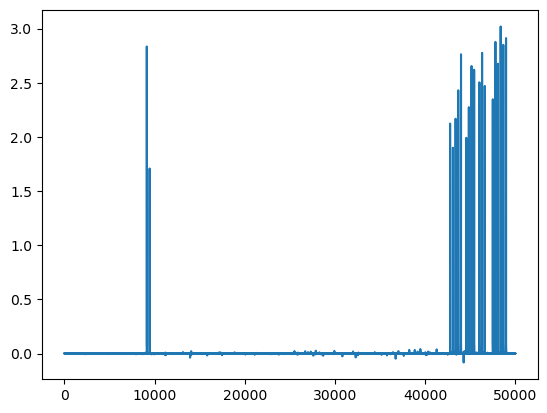

In [218]:
plot(temporal_data[1][:,4])

## testing driving a neuron with temporal data

In [163]:

prefs.codegen.target = 'numpy'
temp_data_dt = 0.2 * ms
A_0_stimulus = TimedArray(temporal_data[0][:,0:2]*2, dt=0.2*ms)

test_neuron = NeuronGroup(2, 'dv/dt = (-v + A_0_stimulus(t, i))/(0.2*ms) : 1 (unless refractory)',
                threshold='v>1', reset='v=0', refractory=5*ms)
#test_neuron.v = 1
test_spike_monitor = SpikeMonitor(test_neuron)
test_state_monitor = StateMonitor(test_neuron, 'v', record=[0,1])

test_runtime = 1000
run(test_runtime*ms)





INFO       No numerical integration method specified for group 'neurongroup_8', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    'i' is an internal variable of group 'neurongroup_8', but also exists in the run namespace with the value 25. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


<spikemonitor_1.t: array([ 14.5,  64.2, 112.1, 157.8, 654.3, 704. , 751.5, 801.9]) * msecond>
[0.00456111 0.00512727 0.00586413 0.00631106 0.0057952  0.00548231
 0.         0.         0.         0.        ]


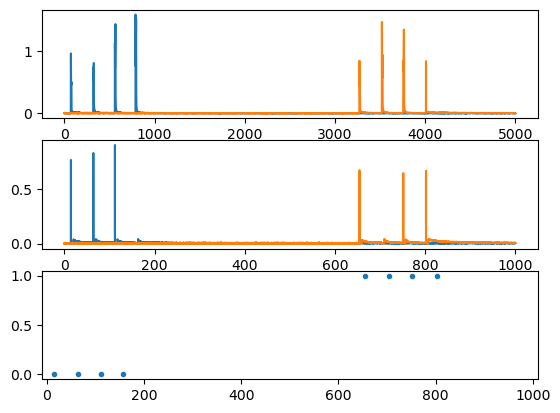

In [146]:
data_voltage_input_fig, axis = plt.subplots(3, 1)

fig_start = 0
axis[0].plot(temporal_data[0][:,0][fig_start:test_runtime*5])
axis[0].plot(temporal_data[0][:,1][fig_start:test_runtime*5])

axis[1].plot(test_state_monitor.t/ms, test_state_monitor.v[0])
axis[1].plot(test_state_monitor.t/ms, test_state_monitor.v[1])

axis[2].plot(test_spike_monitor.t/ms, test_spike_monitor.i, '.')
axis[2].set_xlim(xmin=-10, xmax=test_runtime+10)

print(test_spike_monitor.t)
s_index = 1578
print(test_state_monitor.v[0][s_index-5:s_index+5])

## Creation of network objects

In [172]:
start_scope()
#Create neuron groups
e_neurons = NeuronGroup(n_e, eqs_e, threshold= e_thresh_str, refractory= refrac_e, reset= e_reset_str, method='euler')
i_neurons = NeuronGroup(n_i, eqs_i, threshold= i_thresh_str, refractory= refrac_i, reset= i_reset_str, method='euler')

#set start voltages
e_neurons.v = v_rest_e - 40*mV
i_neurons.v = v_rest_e - 40*mV

#set theta values
e_neurons.theta = np.ones((n_e)) * 20.*mV

## Create connections between the excitatory and inhibitory neurons
# First excitatory to inhibitory synapses
#e_weightMatrix = np.random.rand(n_e, n_i)
e_weightMatrix = np.zeros((n_e,n_i))
np.fill_diagonal(e_weightMatrix, np.random.rand(n_e))

model = 'w : 1'
pre = 'ge_post += w'
post = ''

ei_synapses = Synapses(e_neurons, i_neurons, model=model, on_pre=pre, on_post=post)
ei_synapses.connect(True) #Creates all-to-all connection
ei_synapses.w = e_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


# inhibitory to excitatory synapses
pre = 'gi_post += w'
i_weightMatrix = np.random.rand(n_i, n_e) * weight['ie']
np.fill_diagonal(i_weightMatrix, 0)

ie_synapses = Synapses(i_neurons, e_neurons, model=model, on_pre=pre, on_post=post)
ie_synapses.connect(True) #Creates all-to-all connection
ie_synapses.w = i_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


### The creation of Poisson inputs from vec data
input_weightMatrix = np.random.rand(input_dim, n_e) * weight['ee_input'] #initially random weights
input_neurons = PoissonGroup(5, 0*Hz)


# creation of synapse from input to excitatory
model = 'w : 1' + eqs_stdp_ee
pre = 'ge_post += w; ' + eqs_stdp_pre_ee
post = eqs_stdp_post_ee

input_synapses = Synapses(input_neurons, e_neurons, model=model, on_pre=pre, on_post=post)

min_delay = delay['ee_input'][0]
max_delay = delay['ee_input'][1]
delta_delay = max_delay - min_delay
# TODO: test this ## That was note from brian2 translator, I wonder why, hmm

input_synapses.connect(True) # all-to-all connection
input_synapses.delay = 'min_delay + rand() * delta_delay'
input_synapses.w = input_weightMatrix[input_synapses.i, input_synapses.j]


### Creation of monitors
e_rate_monitor = PopulationRateMonitor(e_neurons)
i_rate_monitor = PopulationRateMonitor(i_neurons)
input_rate_monitor = PopulationRateMonitor(input_neurons)
rate_monitors = [e_rate_monitor, i_rate_monitor, input_rate_monitor]

e_spike_monitor = SpikeMonitor(e_neurons)
i_spike_monitor = SpikeMonitor(i_neurons)
spike_monitors = [e_spike_monitor, i_spike_monitor]

## Running the simulation

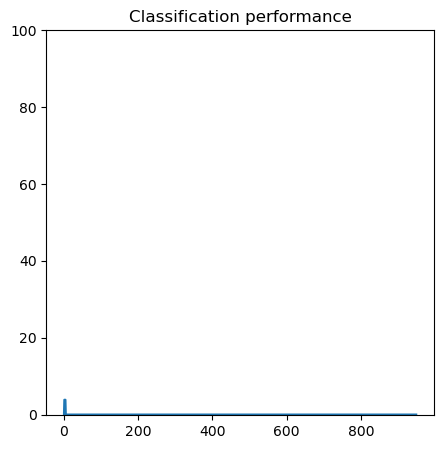

At run  4 of 950

Classification performance  [0.         3.84615385 3.84615385 3.84615385 3.84615385]

Assignments  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

KeyboardInterrupt: 

In [173]:
previous_spike_count = np.zeros(n_e)
#assignments = np.tile(np.linspace(0,25,26), neurons_per_categories)
assignments = np.zeros(n_e)
input_labels = [0] * sample_count # not exactly certain what this one refers to
outputNumbers = np.zeros((sample_count, 26))
performance_monitor, performance, fig_num, fig_performance = plot_performance(fig_num)
#print(assignments)
j=0
while j < sample_count:
    #if j%150 == 0:
    #    clear_output()
    
    spike_rates = training['data'][j%(19*26),:] *  input_intensity
    input_neurons.rates = spike_rates * Hz
    
    normalize_input_weights()
    run(input_sample_time, report = 'text') #, report = 'text'
    #print("")
    
    if j % update_interval == 0 and j > 0:
        #print("new assignments got on sample" + j)
        assignments = get_new_assignments(result_monitor[:], input_labels[j-update_interval : j])
    

    current_spike_count = np.asarray(e_spike_monitor.count[:]) - previous_spike_count
    previous_spike_count = np.copy(e_spike_monitor.count[:])
    if np.sum(current_spike_count) < 5:
        print('skip at ', j)
        print('current spike rates ', training['data'][j%(19*26),:] * input_intensity)
        print('current label', training['labels'][j%epoch_sample_count][0])
        #plot(e_spike_monitor)
        input_intensity += 2
        input_neurons.rates = 0 * Hz
        run(inter_input_time)
        
        
    else:
        result_monitor[j%update_interval,:] = current_spike_count
        input_labels[j] = training['labels'][j%epoch_sample_count][0]
        outputNumbers[j,:] = get_recognized_number_ranking(assignments, result_monitor[j%update_interval,:])
        #if j % 100 == 0 and j > 0:
        #    print('runs done:', j, 'of', int(sample_count))
            
        ####
        if j % update_interval == 0 and j > 0:
            clear_output()
            #print(input_labels[j:])
            #print(output_numbers)
            unused, performance = update_performance_plot(performance_monitor, performance, j, fig_performance)
            print('At run ', int(j/update_interval), 'of', int(sample_count/update_interval))
            print('')
            print('Classification performance ', performance[:int((j/float(update_interval))+1)])
            print('')
            print('Assignments ', assignments)
            #print('Last 26 outputs', outputNumbers[j-26:j,:])
            print('')
            print('Last 26 guesses (top 2) ', outputNumbers[j-26:j,0:2])
            print('')
            print('')
            print('Run reports:')
            
        ####
        
        input_neurons.rates = 0 * Hz
        run(inter_input_time)
        input_intensity = start_input_intensity
        j += 1
    
# Unimportant plotting (a lot more where that came from)
# fig_num, input_weight_fig, fig_weights = plot_2d_input_weights(fig_num)
#     if j % weight_update_interval == 0:
#         update_2d_input_weights(input_weight_monitor, fig_weights)

# this thing is in the original code before the loop, no idea why 
# for i,name in enumerate(input_population_names):
#     input_groups[name+'e'].rates = 0 * Hz
# net.run(0*seb_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [ ]:
# plotting stuff
figure(fig_num)
fig_num += 1
for i, name in enumerate(rate_monitors):
    subplot(len(rate_monitors), 1, 1+i)
    plot(rate_monitors[name].t/b2.second, rate_monitors[name].rate, '.')
    title('Rates of population ' + name)

figure(fig_num)
fig_num += 1
for i, name in enumerate(spike_monitors):
    subplot(len(spike_monitors), 1, 1+i)
    plot(spike_monitors[name].t/b2.ms, spike_monitors[name].i, '.')
    title('Spikes of population ' + name)

if spike_counters:
    b2.figure(fig_num)
    fig_num += 1
    b2.plot(e_spike_monitor.count[:])
    b2.title('Spike count of excitatory population')




# example spiking for one input
# brian_plot(input_monitor).set_title('poisson input example spikes');

# FOR RUNNING THE TEMPORAL DATA

In [220]:
start_scope()
prefs.codegen.target = 'numpy'
temp_data_dt = 0.2 * ms
A_0_stimulus = TimedArray(temporal_data[1][:,0:2]*2, dt=0.2*ms)

test_neuron = NeuronGroup(2, 'dv/dt = (-v + A_0_stimulus(t, i))/(0.2*ms) : 1 (unless refractory)',
                threshold='v>1', reset='v=0', refractory=5*ms)
#test_neuron.v = 1
test_spike_monitor = SpikeMonitor(test_neuron)
test_state_monitor = StateMonitor(test_neuron, 'v', record=[0,1])

test_runtime = 1000
run(test_runtime*ms)





INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


<spikemonitor_1.t: array([0.2563, 0.3168, 0.3756, 0.4348, 0.4956, 0.6682, 0.7219, 0.7752,
       0.8331, 0.8951]) * second>
[ 3.91394811e-05 -3.69730045e-04 -1.01119129e-03 -1.40025720e-03
 -1.24276826e-03 -1.14724640e-03  9.10985677e-05  8.42192755e-04
  1.17346387e-04 -3.22295159e-04]


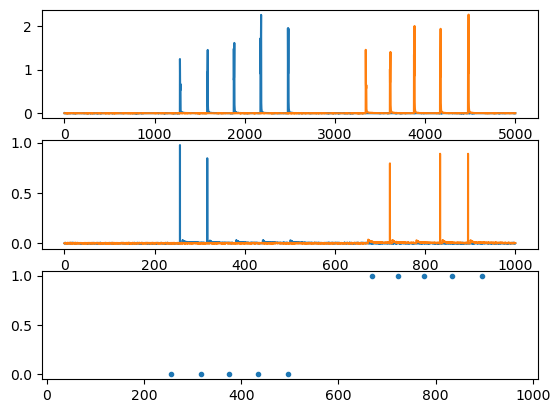

In [222]:
data_voltage_input_fig, axis = plt.subplots(3, 1)

fig_start = 0
axis[0].plot(temporal_data[1][:,0][fig_start:test_runtime*5])
axis[0].plot(temporal_data[1][:,1][fig_start:test_runtime*5])

axis[1].plot(test_state_monitor.t/ms, test_state_monitor.v[0])
axis[1].plot(test_state_monitor.t/ms, test_state_monitor.v[1])

axis[2].plot(test_spike_monitor.t/ms, test_spike_monitor.i, '.')
axis[2].set_xlim(xmin=-10, xmax=test_runtime+10)

print(test_spike_monitor.t)
s_index = 1578
print(test_state_monitor.v[0][s_index-5:s_index+5])

In [26]:
prefs.codegen.target = 'cython'
start_scope()
#Create neuron groups
e_neurons = NeuronGroup(n_e, eqs_e, threshold= e_thresh_str, refractory= refrac_e, reset= e_reset_str, method='euler')
i_neurons = NeuronGroup(n_i, eqs_i, threshold= i_thresh_str, refractory= refrac_i, reset= i_reset_str, method='euler')

#set start voltages
e_neurons.v = v_rest_e - 40*mV
i_neurons.v = v_rest_e - 40*mV

#set theta values
e_neurons.theta = np.ones((n_e)) * 20.*mV

## Create connections between the excitatory and inhibitory neurons
# First excitatory to inhibitory synapses
#e_weightMatrix = np.random.rand(n_e, n_i)
e_weightMatrix = np.zeros((n_e,n_i))
np.fill_diagonal(e_weightMatrix, np.random.rand(n_e))

model = 'w : 1'
pre = 'ge_post += w'
post = ''

ei_synapses = Synapses(e_neurons, i_neurons, model=model, on_pre=pre, on_post=post)
ei_synapses.connect(True) #Creates all-to-all connection
ei_synapses.w = e_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


# inhibitory to excitatory synapses
pre = 'gi_post += w'
i_weightMatrix = np.random.rand(n_i, n_e) * weight['ie']
np.fill_diagonal(i_weightMatrix, 0)

ie_synapses = Synapses(i_neurons, e_neurons, model=model, on_pre=pre, on_post=post)
ie_synapses.connect(True) #Creates all-to-all connection
ie_synapses.w = i_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


### The creation of Poisson inputs from vec data
input_weightMatrix = np.random.rand(input_dim, n_e) * weight['ee_input'] #initially random weights
input_neurons = NeuronGroup(5, '''dv/dt = (-v + stimulus((t-time_var), i))/(0.2*ms) : 1 (unless refractory)''',
                threshold='v>1', reset='v=0', refractory=5*ms)

# creation of synapse from input to excitatory
model = 'w : 1' + eqs_stdp_ee
pre = 'ge_post += w; ' + eqs_stdp_pre_ee
post = eqs_stdp_post_ee

input_synapses = Synapses(input_neurons, e_neurons, model=model, on_pre=pre, on_post=post)

min_delay = delay['ee_input'][0]
max_delay = delay['ee_input'][1]
delta_delay = max_delay - min_delay
# TODO: test this ## That was note from brian2 translator, I wonder why, hmm

input_synapses.connect(True) # all-to-all connection
input_synapses.delay = 'min_delay + rand() * delta_delay'
input_synapses.w = input_weightMatrix[input_synapses.i, input_synapses.j]


### Creation of monitors
e_rate_monitor = PopulationRateMonitor(e_neurons)
i_rate_monitor = PopulationRateMonitor(i_neurons)
input_rate_monitor = PopulationRateMonitor(input_neurons)
rate_monitors = [e_rate_monitor, i_rate_monitor, input_rate_monitor]

e_spike_monitor = SpikeMonitor(e_neurons)
i_spike_monitor = SpikeMonitor(i_neurons)
spike_monitors = [e_spike_monitor, i_spike_monitor]

input_time = 10000*ms

## Running the simulation

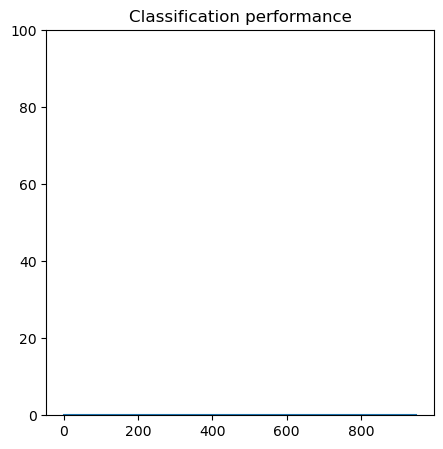

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


weights prior to normalisation:  <synapses_3.w: array([19.70019292, 12.65884296,  8.6920228 , ...,  8.04329856,
       12.42369712,  9.40528828])>
weights post normalisation:  <synapses_3.w: array([23.33554492, 19.53233624, 11.0609954 , ..., 11.2175775 ,
       16.94959679, 18.91271264])>


INFO:root:building '_cython_magic_be22f547d7b28520e2974b0e089d7eba' extension
INFO:root:gcc -pthread -B /share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include -fPIC -O2 -isystem /share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include -fPIC -I/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include -I/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/lib/python3.10/site-packages/numpy/core/include -I/home/vuoriom3/.local/lib/python3.10/site-packages/brian2/synapses -I/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include/python3.10 -c /home/vuoriom3/.cython/brian_extensions/_cython_magic_be22f547d7b28520e2974b0e089d7eba.cpp -o /home/vuoriom3/.cython/bri

Starting simulation at t=0. s for a duration of 10. s
6.3969 s (63%) simulated in 10s, estimated 6s remaining.
10. s (100%) simulated in 16s
[0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO:root:building '_cython_magic_6e4f585268abf1163574dc82ef58cbc5' extension
INFO:root:gcc -pthread -B /share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include -fPIC -O2 -isystem /share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include -fPIC -I/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/include -I/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-02/d63245c4/lib/python3.10/site-packages/numpy/core/include -I/home/vuoriom3/.local/lib/python3.10/site-packages/brian2/synapses -I/share/apps/anaconda-ci/fgci-cent

Starting simulation at t=10. s for a duration of 10. s
6.11 s (61%) simulated in 10s, estimated 6s remaining.
10. s (100%) simulated in 16s


INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
skip at  1
current label  1.0

current weights  <synapses_3.w: array([1., 1., 1., ..., 1., 1., 1.])>

Starting simulation at t=20. s for a duration of 10. s
5.2849 s (52%) simulated in 10s

Exception ignored in: <bound method InstanceTrackerSet.remove of InstanceTrackerSet({<weakref at 0x2b0359e2cf40; to 'SynapticPathway' at 0x2b0359472080>, <weakref at 0x2b0357439da0; to 'CythonCodeObject' at 0x2b035686e080>, <weakref at 0x2b0359e39300; to 'StateUpdater' at 0x2b03595ce0b0>, <weakref at 0x2b0357e2bfb0; to 'Resetter' at 0x2b0358b76110>, <weakref at 0x2b03591411c0; to 'StateUpdater' at 0x2b0358b76230>, <weakref at 0x2b0356fc7470; to 'SpikeMonitor' at 0x2b03592ac250>, <weakref at 0x2b03586b7bf0; to 'PopulationRateMonitor' at 0x2b03586a4340>, <weakref at 0x2b0357cb50d0; to 'CythonCodeObject' at 0x2b0356b16410>, <weakref at 0x2b0359e43ec0; to 'Resetter' at 0x2b0358746470>, <weakref at 0x2b0357e28a90; to 'CythonCodeObject' at 0x2b0359578490>, <weakref at 0x2b035953e610; to 'NeuronGroup' at 0x2b03589124a0>, <weakref at 0x2b0358326570; to 'TimedArray' at 0x2b03587444c0>, <weakref at 0x2b0359e436f0; to 'Thresholder' at 0x2b03587464d0>, <weakref at 0x2b035a2a8bd0; to 'CythonCodeObj

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
skip at  1
current label  1.0

current weights  <synapses_3.w: array([121., 121., 121., ..., 121., 121., 121.])>

Starting simulation at t=40. s for a duration of 10. s


KeyboardInterrupt: 

In [27]:
previous_spike_count = np.zeros(n_e)
#assignments = np.tile(np.linspace(0,25,26), neurons_per_categories)
assignments = np.zeros(n_e)
input_labels = [0] * sample_count # not exactly certain what this one refers to
outputNumbers = np.zeros((sample_count, 26))
performance_monitor, performance, fig_num, fig_performance = plot_performance(fig_num)
print('weights prior to normalisation: ', input_synapses.w)
normalize_input_weights()
print('weights post normalisation: ', input_synapses.w)
#print(assignments)

j=0
while j < sample_count:
    
    #spike_rates = training['data'][j%(19*26),:] *  input_intensity
    stimulus = TimedArray(temporal_data[j%26][:,0:5]*10, dt=0.2*ms)
    time_var = j*10000*ms
    
    run(input_time, report = 'text')
    
    
    
    if j % update_interval == 0 and j > 0:
        #print("new assignments got on sample" + j)
        assignments = get_new_assignments(result_monitor[:], input_labels[j-update_interval : j])
    

    current_spike_count = np.asarray(e_spike_monitor.count[:]) - previous_spike_count
    previous_spike_count = np.copy(e_spike_monitor.count[:])
    print(current_spike_count)
    if np.sum(current_spike_count) < 5:
        print('skip at ', j)
        #print('current spike rates ', training['data'][j%(19*26),:] * input_intensity)
        print('current label ', training['labels'][j%epoch_sample_count][0])
        print('')
        print('current weights ', input_synapses.w)
        print('')

        #plot(e_spike_monitor)
        input_synapses.w *= 11

        
        
    else:
        result_monitor[j%update_interval,:] = current_spike_count
        input_labels[j] = training['labels'][j%epoch_sample_count][0]
        outputNumbers[j,:] = get_recognized_number_ranking(assignments, result_monitor[j%update_interval,:])
        normalize_input_weights()
        #if j % 100 == 0 and j > 0:
        #    print('runs done:', j, 'of', int(sample_count))
            
        ####
        if j % update_interval == 0 and j > 0:
            clear_output()
            #print(input_labels[j:])
            #print(output_numbers)
            unused, performance = update_performance_plot(performance_monitor, performance, j, fig_performance)
            print('At run ', int(j/update_interval), 'of', int(sample_count/update_interval))
            print('')
            print('Classification performance ', performance[:int((j/float(update_interval))+1)])
            print('')
            print('Assignments ', assignments)
            #print('Last 26 outputs', outputNumbers[j-26:j,:])
            print('')
            print('Last 26 guesses (top 2) ', outputNumbers[j-26:j,0:2])
            print('')
            print('')
            print('Run reports:')
        j += 1
    
    
# Unimportant plotting (a lot more where that came from)
# fig_num, input_weight_fig, fig_weights = plot_2d_input_weights(fig_num)
#     if j % weight_update_interval == 0:
#         update_2d_input_weights(input_weight_monitor, fig_weights)

# this thing is in the original code before the loop, no idea why 
# for i,name in enumerate(input_population_names):
#     input_groups[name+'e'].rates = 0 * Hz
# net.run(0*seb_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



[1] Unsupervised learning of digit recognition using spike-timing-dependent plasticity, 03.08.2015, (https://doi.org/10.3389/fncom.2015.00099)

[2] Spiking Neural Network (SNN) With Memristor Synapses Having Non-linear Weight Update, 11.03.2021, frontiers of comp. neuroscience, (https://doi.org/10.3389/fncom.2021.646125)

[3] A recipe for creating ideal hybrid memristive-CMOS neuromorphic computing systems, 11.12.2019, (https://arxiv.org/abs/1912.05637)

[4] Motif-topology improved Spiking Neural Network for the Cocktail Party Effect and McGurk Effect, 12.11.2022, (https://arxiv.org/pdf/2211.07641.pdf)



address these questions:

- Raison d'etre of offset in the architecture
- STDP_offset does what exactly




Random thoughts:
- Connect multiple modalities of inputs to each other. That sounds really good and something that can be done pretty soon after I get this done